In [111]:
!pip install --upgrade pip

In [1]:
!pip install pydot==3.0.2


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Afin de vous simplifier la vie : à chaque modification de projet.py, il sera rechargé par la session jupyter.
%load_ext autoreload
%autoreload 2

# utils.py contient des fonctions et des classes d'aide au projet. IL NE FAUT RIEN CHANGER DANS CE FICHIER
# liste des classes et fonctions de ce fichier :
#  - getNthDict (remplit un dictionnaire avec la ligne n d'un dataframe)
#  - viewData (visualisation d'un dataframe)
#  - discretizeData (discrétisation automatique)
#  - AbstractClassifier (classe abstraite pour tous les classifieurs)
#  - drawGraphHorizontal (dessin d'un graphe orienté horizontal)
#  - drawGraph (dessin d'un graphe orienté vertical)
import utils

# Cette ligne importe vos codes. VOTRE CODE EST A ÉCRIRE DANS projet.py. 
import projet # votre code

### Base utilisée : heart disease (Cleveland database)

        This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. 
        The `target` field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1) from absence (value 0). 

| champs | definition |
|--------|------------|
|age|  age in years| 
|sex| (1 = male; 0 = female)| 
|cp|  chest pain type| 
|trestbps| resting blood pressure (in mm Hg on admission to the hospital)| 
|chol| serum cholestoral in mg/dl| 
|fbs| (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)| 
|restecg| resting electrocardiographic results| 
|thalach| maximum heart rate achieved| 
|exang| exercise induced angina (1 = yes; 0 = no)| 
|oldpeak| ST depression induced by exercise relative to rest| 
|slope|the slope of the peak exercise ST segment| 
|ca| number of major vessels (0-3) colored by flourosopy| 
|thal|3 = normal; 6 = fixed defect; 7 = reversable defect| 
|target| 1 or 0 | 

Notre but est donc de proposer des classifieurs qui tentent de prédire la valeur de `target` à partir des autres champs en utilisant des arguments probabilistes.

## 0- Simplification de la base 

**prélude au projet : pas de travail à faire dans cette partie**

Nous allons prétraiter la base afin de la rendre utilisable pour notre projet. Le travail se fait pour vous. Rien à faire, juste à regarder pour comprendre ce qu'on y fait.

In [3]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python

In [4]:
data=pd.read_csv("data/heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


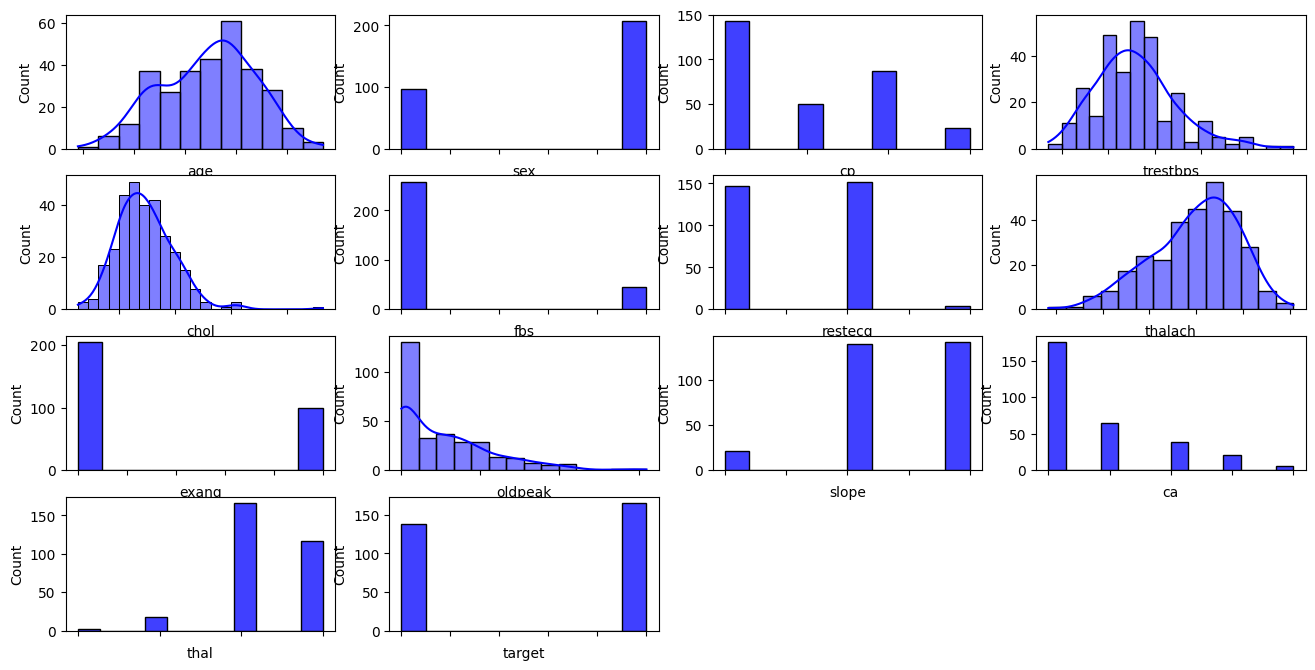

In [12]:
#utils.viewData(data)

Certaines variabless comme `age`, `thalach`, etc. possèdent un grand nombre de modalités, rendant difficile le traitement. Nous simplifions donc la base en discrétisant au mieux toutes les variables qui ont plus de 5 valeurs.

In [5]:
discretise=utils.discretizeData(data)
#utils.viewData(discretise,kde=False)

Nous utilisons maintenant 2 fichiers csv **préparés à l'avance pour ce projet** à partir de cette base afin de rendre les résultats plus intéressants (en particulier, les 2 classes sont un peu plus déséquilibrées).

In [5]:
train=pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")
#utils.viewData(train,kde=False)   

![warning.png](attachment:66a63d49-a129-46c7-aaeb-425657b43c6b.png) À partir de maintenant, nous utilisons le dataframe `train` qui contient les données pour l'apprentissage et `test` qui contient les données pour la validation.

## 1- Classification a priori

### Question 1.1 : calcul de la probabilité a priori
Dans une fonction `getPrior`, calculer la probabilité a priori de la classe $1$ ainsi que l'intervalle de confiance à 95% pour l'estimation de cette probabilité.

In [6]:
def getPrior(df: pd.DataFrame)->dict: 
    """
    Calcule la probabilite a priori de la classe 1 et son intervalle de confiance a 95%

    Parameter
    ---------
        df: np.DataFrame 
            le tableau de donnees 

    Returns
    -------
        Retourne le dictionnaire contenant la probabilite a priori de la classe 1,
        borne inferieure de l'intervalle, borne superieure de l'intervalle      
    """
    # Probabilite estimee par la frequence

    # nombre d'individus
    n = df["target"].count()

    # nombre d'individus de classe target 1 : correspond a notre moyenne empirique
    proba = df['target'][df["target"] == 1].count() / n
    
    # estimation de l'ecart-type par la loi de Bernoulli
    std = np.sqrt(proba * (1 - proba)) 

    # Intervalle de confiance a 95%
    min5percent = -1.96 * std / np.sqrt(n) + proba # moyenne = proba (estimation par bernoulli)
    max5percent = 1.96 * std / np.sqrt(n) + proba
    
    return {'estimation': proba, 'min5pourcent': min5percent, 'max5pourcent': max5percent}

In [7]:
# cette fonction doit donc rendre un dictionnaire contenant 3 clés 'estimation', 'min5pourcent', 'max5pourcent' 
# (L'ORDRE DES CLES N'EST PAS IMPORTANTE DANS UN DICTIONNAIRE)
getPrior(train)


{'estimation': 0.7453874538745388,
 'min5pourcent': 0.7087109975695709,
 'max5pourcent': 0.7820639101795066}

In [8]:
getPrior(test) 

{'estimation': 0.69,
 'min5pourcent': 0.62590170673099,
 'max5pourcent': 0.7540982932690099}

### Question 1.2 : programmation orientée objet dans la hiérarchie des `Classifier`

On propose de représenter les classifieurs en python par des classes d'une hiérarchie. Un classifieur répond à une question principale : étant donné un vecteur d'attributs, quelle est la classe proposée ?
Nous proposons donc une classe de base qu'il s'agira d'**améliorer et de spécialiser en la sous-classant** : `AbstractClassifier` dans le fichier `utils.py` 

Telle qu'elle est définie dans `utils.py`, la classe `AbstractClassifier` ressemble à une *interface* (en Java) : elle décrit sans implémenter les deux méthodes que doivent implémenter les `Classsifier` que vous allez écrire.

- `estimClass` qui à partir d'un dictionnaire tel que :

  `{'age': 9, 'sex': 1, 'cp': 3, 'trestbps': 9, 'chol': 6, 'fbs': 1, 'restecg': 0, 'thalach': 9, 'exang': 0, 'oldpeak': 6, 'slope': 0, 'ca': 0, 'thal': 1, 'target': 1}`

  sera capable de prédire si le patient semble malade ou non en retournant soit `1` soit `0`. (que l'on connait grâce à `target` qu'il ne faut pas utiliser dans le classifieur bien sûr ! &#x1F600; )

- `statsOnDF` qui fournit des statistiques de qualité du `Classifier` en le confrontant à une base de donnée (un `pandas.DataFrame`).

Voici un schéma des classes que vous allez pouvoir créer dans ce projet (en n'affichant que le nom des classes et non le nom des méthodes à implémenter dans chacune):

![classes.png](res/classes.png)

#### Question 1.2.a
Ecrire dans `projet.py` un classifieur `APrioriClassifier` (enfant de `AbstractClassifier`) qui utilise le résultat de la question 1 pour estimer très simplement la classe de chaque individu par la classe majoritaire.  

In [9]:
class APrioriClassifier(utils.AbstractClassifier): #changer dans 

    def __init__(self,data):
        self.data = data
        self.prior = getPrior(data)

    def estimClass(self, d = None):
        return int(self.prior["estimation"] > 0.5)

    def statsOnDF(self, data):
        vp, vn, fp, fn = 0, 0, 0, 0

        for t in data.itertuples(index = False):
            
            d = t._asdict()
            estim_target = self.estimClass(d)
            target = d["target"]
            if target and estim_target:
                vp += 1
            if target and estim_target == 0:
                fn += 1
            if target == 0 and estim_target:
                fp += 1
            if target == 0 and estim_target == 0:
                vn += 1

        precision = vp / (vp + fp) if (vp + fp) > 0 else 0
        rappel = vp / (vp + fn) if (vp + fn) > 0 else 0
            
        return {'VP': vp, 'VN': vn, 'FP': fp, 'FN': fn, 'precision':precision, 'rappel':rappel}
            


In [10]:
cl=APrioriClassifier(train)
clpredite=cl.estimClass({}) # n'importe quoi donne la même classe pour un classifieur a priori 
# la valeur prédite n'est pas affichée sciemment (pour vous laisser chercher) mais doit valoir l'entier 0 ou 1
clpredite

1

#### Question 1.2.b : évaluation de classifieurs

Implémenter également la méthode `statsOnDF` qui rendra les valeurs suivantes :

- VP : `vrai positif`. Le nombre d'individus avec target=1 et classe prévue=1
- VN : `vrai négatif`. Le nombre d'individus avec target=0 et classe prévue=0
- FP : `faux positif`. Le nombre d'individus avec target=0 et classe prévue=1
- FN : `faux négatif`. Le nombre d'individus avec target=1 et classe prévue=0
- précision 
- rappel


![PrecisionRappel.png](res/PrecisionRappel.png)
- <i>Petite aide : comment itérer sur un dataframe</i>

> ```python
> for t in train.itertuples():
>     dic=t._asdict()
>     print(f"ca={dic['ca']} oldpeak={dic['oldpeak']} target={dic['target']}")
> ```

- <i>Par ailleurs, dans `utils.py`, il y a une fonction `getNthDict(df,n)` qui rend le dictionnaire des attributs de la $n$ième ligne dans `df`.</i>

> ```python
> >>> getNthDict(train,0)
> {'age': 9, 'sex': 1, 'cp': 3, 'trestbps': 9, 'chol': 6, 'fbs': 1, 'restecg': 0, 'thalach': 9, 'exang': 0, 'oldpeak': 6, 'slope': 0, 'ca': 0, 'thal': 1, 'target': 1}
> ```


In [11]:
cl=APrioriClassifier(train)
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

test en apprentissage : {'VP': 404, 'VN': 0, 'FP': 138, 'FN': 0, 'precision': 0.7453874538745388, 'rappel': 1.0}
test en validation: {'VP': 138, 'VN': 0, 'FP': 62, 'FN': 0, 'precision': 0.69, 'rappel': 1.0}


![warning.png](res/warning.png) Si la méthode `statsOnDF` est correctement écrite, elle sera la même pour tous les prochains classifieurs. **Afin de ne pas avoir à réécrire cette méthode `statsOnDF` qui ne devrait pas changer, on fera hériter tous les classifieurs de `AprioriClassifier plutôt que de `AbstractClassfier`** (voir le schéma en début de section 1.2).

## 2- classification probabiliste à 2 dimensions

La classification a priori ne donne pas d'excellents résultats puiqu'elle se contente de la règle majoritaire. On se propose donc maintenant essayer d'enrichir notre processus de décision en tenant compte d'une caractéristique de la base de données.

### Question 2.1 : probabilités conditionelles

#### Question 2.1.a

Écrire une fonction `P2D_l(df,attr)` qui calcule dans le dataframe `df` la distribution de probabilité $P(attr|target)$ sous la forme d'un dictionnaire asssociant à la valeur $t$ un dictionnaire associant à la valeur $a$ la probabilité $P(attr=a|target=t)$.

In [12]:
#fonction en dehors classe
def P2D_l(data, attr:str):
    # calcul P(thal=a|target=t)
    tuples = data[[attr, 'target']].value_counts().to_dict()
    
    total_target = dict()

    # Calc nombre total de chaque valeur de target
    for (_, t), count in tuples.items():
        #print(t, count)
        if t not in total_target:
            total_target[t] = count
        else:
            total_target[t] += count

    proba = {t : {a:0 for a in data[attr].unique()} for t in total_target.keys()}
    # Calc la proba pour chaque valeur d'attr
    for (a, t), count in tuples.items():
        proba[t][a] = count / total_target[t]
    
    return proba



In [13]:
p_thal_given_target=P2D_l(train,'thalach') # calcul P(thal=a|target=t)

print(p_thal_given_target)
print()
#print(f"Dans la base train, la probabilité que thal=3 sachant que target=1 est {p_thal_given_target[1][3]}")

{1: {9: 0.16336633663366337, 13: 0.05693069306930693, 11: 0.1782178217821782, 12: 0.1485148514851485, 10: 0.24257425742574257, 8: 0.08663366336633663, 5: 0.03217821782178218, 6: 0.04455445544554455, 7: 0.027227722772277228, 15: 0.007425742574257425, 14: 0.007425742574257425, 3: 0.0024752475247524753, 4: 0.0024752475247524753, 2: 0, 1: 0}, 0: {9: 0.13043478260869565, 13: 0, 11: 0.07971014492753623, 12: 0.036231884057971016, 10: 0.14492753623188406, 8: 0.17391304347826086, 5: 0.08695652173913043, 6: 0.11594202898550725, 7: 0.12318840579710146, 15: 0, 14: 0.007246376811594203, 3: 0.036231884057971016, 4: 0.050724637681159424, 2: 0.007246376811594203, 1: 0.007246376811594203}}



#### Question 2.1.b
Écrire une fonction `P2D_p(df,attr)` qui calcule dans le dataframe la probabilité $P(target|attr)$ sous la forme d'un dictionnaire associant à la valeur $a$ un dictionnaire asssociant à la valeur $t$ la probabilité $P(target=t|attr=a)$.

In [14]:
#fonction hors classe
def P2D_p(data,attr):
    #calcul P(target=t|thal=a) = P(thal=a,target=t)/P(thal=a) 

    # calcul P(thal=a|target=t)
    tuples = data[[attr, 'target']].value_counts().to_dict()
    total_attr = dict()

    # Calc nombre total de chaque valeur de attr
    for (attr, t), count in tuples.items():
        #print(att, t, count)
        if attr not in total_attr:
            total_attr[attr] = count
        else:
            total_attr[attr] += count

    proba = {a : {t : 0 for t in data['target'].unique()} for a in total_attr.keys()}
    # Calc la proba pour chaque valeur de target
    for (a, t), count in tuples.items():
        #print((a, t), count)
        proba[a][t] = count / total_attr[a]

    #--------
    return proba

In [15]:
p_target_given_thal=P2D_p(train,'thalach')

print(p_target_given_thal)
print()
print(f"Dans la base train, la probabilité que target=1 sachant que thal=3 est {p_target_given_thal[3][1]}")

{10: {1: 0.8305084745762712, 0: 0.1694915254237288}, 11: {1: 0.8674698795180723, 0: 0.13253012048192772}, 9: {1: 0.7857142857142857, 0: 0.21428571428571427}, 12: {1: 0.9230769230769231, 0: 0.07692307692307693}, 8: {1: 0.5932203389830508, 0: 0.4067796610169492}, 13: {1: 1.0, 0: 0}, 6: {1: 0.5294117647058824, 0: 0.47058823529411764}, 7: {1: 0.39285714285714285, 0: 0.6071428571428571}, 5: {1: 0.52, 0: 0.48}, 4: {1: 0.125, 0: 0.875}, 3: {1: 0.16666666666666666, 0: 0.8333333333333334}, 14: {1: 0.75, 0: 0.25}, 15: {1: 1.0, 0: 0}, 2: {1: 0, 0: 1.0}, 1: {1: 0, 0: 1.0}}

Dans la base train, la probabilité que target=1 sachant que thal=3 est 0.16666666666666666


### Question 2.2 : classifieurs 2D par maximum de vraisemblance

Supposons qu'un individu ait la valeur $a$ pour $attr$, un classifieur du type $P2D_l$ pourrrait donc utiliser  $P(attr=a|target=t)$ et sélectionner comme estimation de la classe de l'individu la valeur $t=0$ ou $t=1$ maximisant cette probabilité. $P(attr=a|target)$ est la vraisemblance d'observer $attr=a$ quand $target=0$ ou $target=1$. Un tel classifieur utilise donc le principe du **maximum de vraisemblance** (ML=Max Likelihood). 

- Pour construire un tel classifieur (dans la méthode `__init__`), il faut initialiser l'attribut utilisé puis construire la table `P2Dl`.
- La fonction `estimClass` rendra la position du maximum trouvé dans cette table.


> Supposons un individu dont $thal=3$, alors dans la table P2Dl, on trouve $0.178$ pour $target=1$ et $0.644$ pour $target=0$, la bonne classe d'après le critère du ML est donc $0$

Écrire une classe `ML2DClassifier` qui utilise une telle procédure de maximum de vraisemblance pour estimer la classe d'un individu. Afin de ne pas avoir à réécrire la méthode `statsOnDF` qui ne devrait pas changer, `ML2DClassifier` aura pour parent la classe `APrioriClassifier`.

**PS**- penser bien à calculer une seule fois la table `P2Dl` dans le constructeur de la classe afin de ne pas itérer sur toute la base à chaque fois que vous appelez la méthode `estimClass`.

**PS2**- Dans les cas de la stricte égalité des 2 probabilités, on choisira la classe $0$.

In [16]:
class ML2DClassifier(APrioriClassifier):
    def __init__(self,df,attr):
        super().__init__(df)
        self.P2Dl = P2D_l(df,attr)
        self.attr = attr

    def estimClass(self,d=None) -> int:
        #cas plusieurs valeur target?
        indiv_attr = d[self.attr]
        return int(self.P2Dl[1][indiv_attr] > self.P2Dl[0][indiv_attr])

In [17]:
cl=ML2DClassifier(train,'thal') # cette ligne appelle projet.P2Dl(train,"thal")
for i in [0,1,2]:
    print("Estimation de la classe de l'individu {} par ML2DClassifier : {}".format(i,cl.estimClass(utils.getNthDict(train,i))))

Estimation de la classe de l'individu 0 par ML2DClassifier : 0
Estimation de la classe de l'individu 1 par ML2DClassifier : 1
Estimation de la classe de l'individu 2 par ML2DClassifier : 1


In [26]:
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

test en apprentissage : {'VP': 319, 'VN': 101, 'FP': 37, 'FN': 85, 'precision': 0.8960674157303371, 'rappel': 0.7896039603960396}
test en validation: {'VP': 113, 'VN': 48, 'FP': 14, 'FN': 25, 'precision': 0.889763779527559, 'rappel': 0.8188405797101449}


### Question 2.3 : classifieurs 2D par maximum a posteriori

Supposons qu'un individu ait la valeur $a$ pour l'$attr$, un classifieur du type $P2D_p$ pourrrait donc utiliser  $P(target=t|attr=a)$ et sélectionner comme estimation de la classe de l'individu la valeur $t=0$ ou $t=1$ maximisant cette probabilité. $P(target|attr=a)$ est la distribution a posteriori de $target$ après avoir observé $attr=a$. Un tel classifieur utilise donc le principe du **maximum a posteriori** (MAP). 

Pour construire un tel classifieur, il faut initialiser l'attribut utilisé puis construire la table `P2Dp`. La fonction `estimClass` rendra la position du maximum trouvé dans cette table.

> Supposons un individu dont $thal=3$, alors dans la table P2Dp, on trouve $0.447$ pour $target=1$ et $0.552$ pour $target=0$, la bonne classe d'après le critère du MAP est donc $0$

Écrire une classe `MAP2DClassifier` qui utilise une telle procédure de maximum a posteriori pour estimer la classe d'un individu. Afin de ne pas avoir à réécrire la méthode `statsOnDF` qui ne devrait pas changer, `MAP2DClassifier` héritera de `AprioriClassifier`.

**PS**- penser bien à calculer une seule fois la table `P2Dp` dans le constructeur afin de ne pas itérer sur toute la base à chaque fois que vous appelez la méthode `estimClass`.

**PS2**- Dans les cas d'égalité des 2 probabilités, on choisira la classe 0.

In [18]:
class MAP2DClassifier(APrioriClassifier):
    def __init__(self,df,attr):
        super().__init__(df)
        self.P2Dp = P2D_p(df,attr)
        self.attr = attr
        
    def estimClass(self,d) -> int:
        indiv_attr = d[self.attr]
        return int(self.P2Dp[indiv_attr][1] > self.P2Dp[indiv_attr][0])

In [19]:
cl=MAP2DClassifier(train,"thal") # cette ligne appelle projet.P2Dp(train,"thal")
for i in [0,1,2]:
    print("Estimation de la classe de l'individu {} par MAP2DClasssifer) : {}".format(i,cl.estimClass(utils.getNthDict(train,i)))) 

Estimation de la classe de l'individu 0 par MAP2DClasssifer) : 1
Estimation de la classe de l'individu 1 par MAP2DClasssifer) : 1
Estimation de la classe de l'individu 2 par MAP2DClasssifer) : 1


In [20]:
print("test en apprentissage : {}".format(cl.statsOnDF(train)))
print("test en validation: {}".format(cl.statsOnDF(test)))

test en apprentissage : {'VP': 332, 'VN': 89, 'FP': 49, 'FN': 72, 'precision': 0.8713910761154856, 'rappel': 0.8217821782178217}
test en validation: {'VP': 114, 'VN': 43, 'FP': 19, 'FN': 24, 'precision': 0.8571428571428571, 'rappel': 0.8260869565217391}


### Question 2.4 : comparaison

![question.png](attachment:05f462a9-8752-4d94-8d6a-f86660a5275e.png)
Quelle classifieur préférez-vous en théorie entre `APrioriClassifier`, `ML2DClassifier` et `MAP2DClassifier` ? Quels résultats vous semble-les plus intéressants ?

Cette question ouverte doit donc être répondue dans `projet.py` sous la forme :

> ```python
> #####
> # Question 2.4 : comparaison
> #####
> # Nous préférons ... parce que ...
> # et aussi parce que ...
> #####
> ```


## 3- Complexités

On peut bien sûr se dire que les classifieurs ont intérêt à utiliser le plus d'information possible. Il serait donc pertinent de construire les classifieurs `ML3DClassifier`, `MAP3DClassifier`, ..., `ML14DClassifier` et `MAP14DClassifier` où les `...xDClassifier` prendrait $x-1$ attributs pour construire la prédiction de `target`. 

Toutefois, un problème va nous arrêter : les tables $P14Da$ et $P14Db$ sont de bien trop grande tailles !! 

### Question 3.1 : complexité en mémoire

Écrire une fonction `nbParams` qui affiche la taille mémoire de ces tables $P(target|attr_1,..,attr_k)$ étant donné un dataframe et la liste $[target,attr_1,...,attr_l]$ en supposant qu'un float est représenté sur 8octets. Si la liste des attributs n'est pas fourni, cette fonction doit considérer qu'on utilise tous les attributs disponibles

![warning.png](attachment:c4503214-77ad-4f9f-abb9-b0ed50efd42d.png) La fonction affiche le résultat en Go,Mo,Ko etc. mais retourn le nombre d'octets !

In [21]:
def convert(n:int) -> list[int]:
    unit = 1 << 30 # starting point 2^30 = gb in bytes
    if n >= 1024: 
        print("=", end = ' ')
    names = ['o', 'ko', 'mo', 'go']
    print_flag = False
    i = 3
    while i >= 0:
        if unit == 0:
            unit = 1 # bytes
        q = 0
        if n >= unit:
            print_flag = True if unit != 1 else print_flag
            q = n // unit 
            n -= q * unit

        if print_flag:
            print(f"{q}{names[i]}", end = ' ')
            
        i -= 1
        unit >>= 10
    print('')
   
def nbParams(data, l_attr = None):
    #pas l_attr = tous les attributs
    if l_attr is None:
        l_attr = data.columns.values
    float_bytes = 8
    all_bytes = data[l_attr].nunique().prod() * float_bytes
    print(f"{len(l_attr)} variable(s) : {all_bytes} octets", end = ' ')
    convert(all_bytes)
    return all_bytes
    #print(nb_target)
    #nb_diff_tuples = data[[attrs]].value_counts()
    #print(nb_diff_tuples)

In [22]:
nbParams(train,['target'])
nbParams(train,['target','thal'])
nbParams(train,['target','age'])
nbParams(train,['target','age','thal','sex','exang'])
nbParams(train,['target','age','thal','sex','exang','slope','ca','chol'])
nbParams(train) # seul résultat visible en sortie de cellule

1 variable(s) : 16 octets 
2 variable(s) : 64 octets 
2 variable(s) : 208 octets 
5 variable(s) : 3328 octets = 3ko 256o 
8 variable(s) : 798720 octets = 780ko 0o 
14 variable(s) : 58657996800 octets = 54go 644mo 640ko 0o 


58657996800

On ne peut donc pas manipuler de telles tables et il faut trouver de nouvelles façon de représenter les distributions de probabilités, quitte à en faire des approximations. 

La meilleure façon de simplifier la représentation d'une distribution de probabilité est d'utiliser des hypothèses d'indépendances. Ainsi, dans une loi jointe des variables $A,B,C,D,E$, si on suppose l'indépendance mutuelle de ces 5 variables, on sait qu'on pourra écrire que $$P(A,B,C,D,E)=P(A)*P(B)*P(C)*P(D)*P(E)$$ et donc remplacer un tableau à 5 dimensions par 5 tableaux monodimensionnels.

### Question 3.2 : complexité en mémoire sous hypothèse d'indépendance complète

Écrire une fonction `nbrParamsIndep` qui calcule la taille mémoire nécessaire pour représenter les tables de probabilité étant donné un dataframe, en supposant qu'un float est représenté sur 8octets et **en supposant l'indépendance des variables**.

![warning.png](attachment:178a26d2-d658-4412-b0ca-ed5bb58c6a60.png) La fonction affiche le résultat et **rend la valeur calculée en octets** !

In [23]:
def nbParamsIndep(df):
    float_bytes = 8
    all_bytes = df.nunique().sum() * float_bytes
    print(f"{len(df.columns)} variable(s) : {all_bytes} octets", end = ' ')
    convert(all_bytes)
    return all_bytes

In [24]:
nbParamsIndep(train[['target']])
nbParamsIndep(train[['target','thal']])
nbParamsIndep(train[['target','age']])
nbParamsIndep(train[['target','age','thal','sex','exang']])
nbParamsIndep(train[['target','age','thal','sex','exang','slope','ca','chol']])
nbParamsIndep(train) # seul résultat visible en sortie de cellule

1 variable(s) : 16 octets 
2 variable(s) : 48 octets 
2 variable(s) : 120 octets 
5 variable(s) : 184 octets 
8 variable(s) : 376 octets 
14 variable(s) : 800 octets 


800

### Question 3.3 : indépendance conditionnelle

L'indépendance complète comme ci-dessus amène forcément à un classifier a priori (aucun attribut n'apporte d'information sur `target`).

Nous allons donc essayer de trouver des modèles supposant une certaine forme d'indépendance partielle qui permettra d'alléger quand même la représentation en mémoire de la distribution de probabilités. Ce sont les indépendances conditionnelles. Si l'on sait par exemple que $A$ est indépendant de $C$ sachant $B$, on peut écrire la loi jointe :
$$P(A,B,C)=P(A)*P(B|A)*P(C|B)$$

#### Question 3.3.a : preuve
![question.png](attachment:591bfc9d-8e1b-409e-abf1-4c2d5c32c9a7.png) Pouvez vous le prouvez ?

#### Question 3.3.b : complexité en indépendance partielle

![question.png](attachment:7f1d77b1-cc5b-4e01-baf6-47844bd20c62.png) Si les 3 variables $A$, $B$ et $C$ ont $5$ valeurs, quelle est la taille mémoire en octet nécessaire pour représenter cette distribution avec et sans l'utilisation de l'indépendance conditionnelle ?

**Sans indépendance conditionnelle**: $5^3$ * float_size * nb(target)
**Avec indépendance conditionnelle**: $5^2 * 2 + 5$ * float_size * nb(target)

## 4- Représentation des indépendances conditionnelles : Modèles graphiques

Afin de représenter efficacement les indépendances conditionnelles utilisées pour représenter une distribution jointe de grande taille, on peut utiliser un graphe orienté qui se lit ainsi : dans la décomposition de la loi jointe, chaque variable $X$ apparaitra dans un facteur de la forme $P(X|Parents_X)$.  On note que cette factorisation n'a de sens que si le graphe n'a pas de circuit (c'est un DAG).

Ainsi, on représente la factorisation $P(A,B,C)=P(A)*P(B|A)*P(C|B)$ par le graphe suivant : $A$ n'a pas de parent, $B$ a pour parent $A$ et $C$ a pour parent $B$.

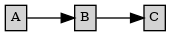

In [33]:
utils.drawGraphHorizontal("A->B;B->C")

### Question 4.1 : Exemples

![question.png](attachment:ab9a4244-ed53-44b5-8ac9-73396c881d69.png) Proposer le code pour dessiner les graphes pour 5 variables $A,B,C,D,E$ complètement indépendantes puis pour ces 5 même variables sans aucune indépendance.

(vous pouvez tester dans les 2 cellules suivantes, mais n'oubliez pas de reporter votre proposition dans `projet.py`)

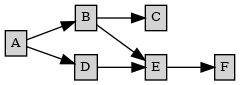

In [34]:
utils.drawGraphHorizontal("A->B->C;A->D->E->F;B->E") # 

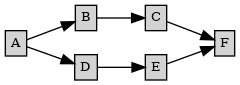

In [35]:
utils.drawGraphHorizontal("A->B->C->F;A->D->E->F") # ce graphe n'est qu'un exemple

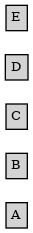

In [36]:
utils.drawGraphHorizontal("A;B;C;D;E") # indep

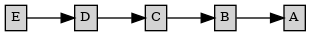

In [37]:
utils.drawGraphHorizontal("E->D->C->B->A") # non indep

### Question 4.2 : naïve Bayes

Un modèle simple souvent utilisée est le **Naïve Bayes**. Il suppose que $2$ attributs sont toujours indépendants conditionnellement à `target`.

Ce modèle est évidemment très simpliste et certainement faux. Toutefois, en classification, il donne souvent de bon résultats.

![question.png](attachment:ec10eefd-054d-48c0-87d6-8a63197550e4.png)

- Écrire comment se décompose la vraisemblance $P(attr1,attr2,attr3,\cdots|target)$.

- Écrire comment se décompose la distribution a posteriori $P(target|attr1,attr2,attr3,\cdots) = \dfrac{P(attr1|target) \cdot P(attr2|target) \cdots P(attrN|target) \cdot P(target)}{P(attr1,attr2,attr3,\cdots)} = \dfrac{P(attr1|target) \cdot P(attr2|target) \cdots P(attrN|target) \cdot P(target)}{\sum_t P(attr1 | target = t) \times \cdots P(attrN |target = t)) * P(target = t)}$.

### Question 4.3 : modèle graphique et naïve bayes

Un modèle naïve bayes se représente sous la forme d'un graphe où le noeud `target` est l'unique parent de tous les attributs. 

#### Question 4.3.a

Construire une fonction `drawNaiveBayes` qui a partir d'un dataframe et du nom de la colonne qui est la classe, dessine le graphe. 

**Note** : une fonction qui dessine un graphe retourne un appel à `utils.drawGraph`, par exemple :

```python
def dessin_A_vers_B():
  return utils.drawGraph("A->B")
```

In [25]:
def drawNaiveBayes(df, parent):
    l_attr = df.columns.values
    liste = []
    for attr in l_attr:
        if attr != parent:
            liste.append(f"{parent}->{attr}")
    chaine = ";".join(liste)
    return utils.drawGraph(chaine)

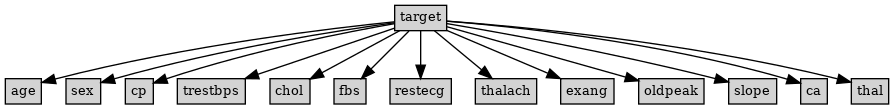

In [74]:
drawNaiveBayes(train,"target")

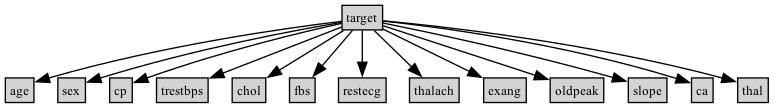

In [22]:
projet.drawNaiveBayes(train,"target")

#### Question 4.3.b

Écrire une fonction `nbrParamsNaiveBayes` qui écrit la taille mémoire nécessaire pour représenter les tables de probabilité étant donné un dataframe, en supposant qu'un float est représenté sur 8octets et **en utilisant l'hypothèse du Naive Bayes**.

![warning.png](attachment:bcb30f63-7ccd-45ef-9a67-df8299a4cbce.png) Comme plus haut, la fonction affiche le résultat et retourn le nombre d'octets !

In [26]:
### QUESTION (pour le prof): Pourquoi target est passé nécessairement en l_attr?
def nbParamsNaiveBayes(data, parent, l_attr = None):
    #pas l_attr = tous les attributs
    float_bytes = 8
    parent_nb = data[parent].nunique()
    

    #if l_attr == []:
        #return parent_nb * float_bytes

    if l_attr is None:
        l_attr = data.columns
    else:
        l_attr = np.array(l_attr)

    nb_vars = len(l_attr)
    
    if l_attr.size != 0:
        l_attr = l_attr[l_attr != parent] # supprimer parent

    data_count = data[l_attr].nunique() if l_attr.size != 0 else [0]
    # +1 vient de la factorisation
    all_bytes = (sum(data_count) + 1) * float_bytes * parent_nb 
    print(f"{nb_vars} variable(s) : {all_bytes} octets", end = ' ')
    convert(all_bytes)
    return all_bytes

In [150]:
nbParamsNaiveBayes(train,'target',[])
nbParamsNaiveBayes(train,'target',['target','thal'])
nbParamsNaiveBayes(train,'target',['target','age'])
nbParamsNaiveBayes(train,'target',['target','age','thal','sex','exang'])
nbParamsNaiveBayes(train,'target',['target','age','thal','sex','exang','slope','ca','chol'])
nbParamsNaiveBayes(train,'target') # seul résultat visible en sortie de cellule

0 variable(s) : 16 octets 
2 variable(s) : 80 octets 
2 variable(s) : 224 octets 
5 variable(s) : 352 octets 
8 variable(s) : 736 octets 
14 variable(s) : 1584 octets = 1ko 560o 


1584

In [42]:
train[['target','thal']].nunique()

target    2
thal      4
dtype: int64

On voit que l'augmentation de la mémoire nécessaire est très raisonnable.

### Question 4.4 : Classifieur naïve bayes

Écrire les classes `MLNaiveBayesClassifier` et `MAPNaiveBayesClassifier` qui utilise le maximum de vraisemblance (ML) et le maximum a posteriori (MAP) pour estimer la classe d'un individu en utilisant l'hypothèse du Naïve Bayes.

![warning.png](attachment:8a066424-5e0b-4bde-a63b-963e1f247da5.png) De la même façon que plus haut, penser à calculer tous les paramètres du Naïve Bayes dans le constructeur de la classe afin de ne pas les recalculer pour chaque classification.

Décomposer la méthodes `estimClass` en 2 parties : `estimProbas` qui calcule la vraisemblance et `estimClass` qui utilise `estimProbas` pour choisir la classe comme dans les classifieurs précédents.

In [40]:
def init_mat_P2D(df, prior_1):
    P2D_l_mat = {attr : P2D_l(df, attr) for attr in df.columns.values if attr != 'target'}
    P2D_l_mat['target'] = {0: 1-prior_1['estimation'], 1: prior_1['estimation']}
    return P2D_l_mat

#MLNaiveBayesClassifier
class MLNaiveBayesClassifier(APrioriClassifier): 
    def __init__(self, df):
        super().__init__(df)
        self.P2D_ml = init_mat_P2D(df, self.prior)

    def estimProbas(self, d : dict)->dict: 
        """
        Calcule la vraissemblance pour chaque valeur de target 

        Parameters
        ----------
            d: Dict[str,value]
                le dictionnaire nom-valeur des attributs d'un individu 
        
        Returns
        -------
            Retourne Dict[int,value] la vraissemblance pour chaque valeurs de target
        """
        #probabilites
        targets = {0, 1}
        probas = {t : 1 for t in targets} # target : P(a1 ... an | target)
        for t in targets:
            #parcours des attributs et leurs valeurs de l'individu
            for attr, val in d.items():
        
                #verification de la presence de l'attribut dans P2D_ml
                if attr in self.P2D_ml and attr != 'target': #on ne calcule pas target

                    if val in self.P2D_ml[attr][t]:
                        #multiplication par P(attr|target = t)
                        probas[t] *= self.P2D_ml[attr][t][val]
                    else:
                        #val pas dans P2D_l_mat[attr] alors P(attr|target = t) = t
                        probas[t] = 0

        return probas


    def estimClass(self, d:dict)->int: 
        """
        Estime la classe de l'individu suivant maximum de vraissemblance sous l'hypothese du Naive Bayes

        Parameters
        ----------
        d: Dict[str, value]
            le dictionnaire nom-valeur des attributs d'un individu 

        Returns
        -------
            Retourne 0 ou 1, la classe estimee par le maximum de vraissemblance
        
        """
        
        probas = self.estimProbas(d)
        return int(probas[1] > probas[0])

In [41]:
class MAPNaiveBayesClassifier(APrioriClassifier): #a posteriori
    def __init__(self, df):
        super().__init__(df)
        self.P2D_map = init_mat_P2D(df, self.prior)

    def estimProbas(self, d:dict):
        targets = {0, 1}
        probas = {target:1 for target in targets}
        for target in targets:
            # Calc multiplication
            s = 0
            for attr, val in d.items():
                if attr != 'target' and attr in self.P2D_map:
                    if val in self.P2D_map[attr][target]:
                        probas[target] = probas[target] * self.P2D_map[attr][target][val]
                    else:
                        probas[target] = 0
                        break
            probas[target] *= self.P2D_map['target'][target]
        s = sum(probas.values())

        # Trouver proba P(attr1, attr2, ... | target)
        for target in targets:
            probas[target] = probas[target] / s if s else 0
            
        return probas

    def estimClass(self, d):
        probas = self.estimProbas(d)
        return int(probas[1] > probas[0])

In [43]:

cl=MLNaiveBayesClassifier(train)
train.columns.values
utils.getNthDict(train,0)

{'age': 9,
 'sex': 1,
 'cp': 3,
 'trestbps': 9,
 'chol': 6,
 'fbs': 1,
 'restecg': 0,
 'thalach': 9,
 'exang': 0,
 'oldpeak': 6,
 'slope': 0,
 'ca': 0,
 'thal': 1,
 'target': 1}

In [42]:
cl=MLNaiveBayesClassifier(train)

for i in [0,1,2]:
    print(f"Estimation de la proba de l'individu {i} par MLNaiveBayesClassifier : {cl.estimProbas(utils.getNthDict(train,i))}")
    print(f"Estimation de la classe de l'individu {i} par MLNaiveBayesClassifier : {cl.estimClass(utils.getNthDict(train,i))}") 
    print("------")

print(f"test en apprentissage : {cl.statsOnDF(train)}")
print(f"test en validation    : {cl.statsOnDF(test)}") 

Estimation de la proba de l'individu 0 par MLNaiveBayesClassifier : {0: 5.265474022893807e-11, 1: 8.779438846356187e-12}
Estimation de la classe de l'individu 0 par MLNaiveBayesClassifier : 0
------
Estimation de la proba de l'individu 1 par MLNaiveBayesClassifier : {0: 0.0, 1: 1.9903404816168002e-09}
Estimation de la classe de l'individu 1 par MLNaiveBayesClassifier : 1
------
Estimation de la proba de l'individu 2 par MLNaiveBayesClassifier : {0: 3.6835223975945704e-10, 1: 1.5920340255297033e-06}
Estimation de la classe de l'individu 2 par MLNaiveBayesClassifier : 1
------
test en apprentissage : {'VP': 350, 'VN': 116, 'FP': 22, 'FN': 54, 'precision': 0.9408602150537635, 'rappel': 0.8663366336633663}
test en validation    : {'VP': 49, 'VN': 60, 'FP': 2, 'FN': 89, 'precision': 0.9607843137254902, 'rappel': 0.35507246376811596}


In [44]:
cl=MAPNaiveBayesClassifier(train)

for i in [0,1,2]:
    print(f"Estimation de la proba de l'individu {i} par MAPNaiveBayesClassifier : {cl.estimProbas(utils.getNthDict(train,i))}")
    print(f"Estimation de la classe de l'individu {i} par MAPNaiveBayesClassifier : {cl.estimClass(utils.getNthDict(train,i))}") 
    print("------")
print(f"test en apprentissage : {cl.statsOnDF(train)}")
print(f"test en validation    : {cl.statsOnDF(test)}")

Estimation de la proba de l'individu 0 par MAPNaiveBayesClassifier : {0: 0.6719863008964104, 1: 0.3280136991035896}
Estimation de la classe de l'individu 0 par MAPNaiveBayesClassifier : 0
------
Estimation de la proba de l'individu 1 par MAPNaiveBayesClassifier : {0: 0.0, 1: 1.0}
Estimation de la classe de l'individu 1 par MAPNaiveBayesClassifier : 1
------
Estimation de la proba de l'individu 2 par MAPNaiveBayesClassifier : {0: 7.902679489883747e-05, 1: 0.9999209732051012}
Estimation de la classe de l'individu 2 par MAPNaiveBayesClassifier : 1
------
test en apprentissage : {'VP': 382, 'VN': 111, 'FP': 27, 'FN': 22, 'precision': 0.9339853300733496, 'rappel': 0.9455445544554455}
test en validation    : {'VP': 53, 'VN': 57, 'FP': 5, 'FN': 85, 'precision': 0.9137931034482759, 'rappel': 0.38405797101449274}


## 5- *Feature selection* dans le cadre du classifier naive bayes

Il est possible qu'un attribut de la base ne soit pas important pour estimer la classe d'un individu. Dans le cadre du Naïve Bayes, un tel noeud se reconnaît car il est indépendant de `target`. Un tel noeud peut être supprimé du Naïve Bayes.

### Question 5.1

Écrire une fonction `isIndepFromTarget(df,attr,x)` qui vérifie si `attr` est indépendant de `target` au seuil de x%.

*Note* : vous avez le droit d'utiliser `scipy.stats.chi2_contingency` dans cette fonction.

In [45]:
from scipy.stats import chi2_contingency

def isIndepFromTarget(df, attr, crit_level):
    #get the attr values and target
    #from all row in df, form table to be used
    contingency_table = pd.crosstab(index = df[attr], columns=df['target'])
    
    res = chi2_contingency(contingency_table) 
    # if p < 0.01 -> rejet -> dépendance  
    # if p >= 0.01 -> accept -> indépendence
    return res.pvalue >= crit_level #marche dans jupyter, oui

for attr in train.keys():
    if attr!='target':
        print(f"target independant de {attr} ? {'YES' if isIndepFromTarget(train,attr,0.01) else 'no'}")

def getIndepFromTarget(df, crit_level):
    attrs = [attr for attr in df.columns.values if attr != 'target' and (not isIndepFromTarget(df, attr, crit_level))]
    attrs.append('target')
    return attrs 
print(getIndepFromTarget(train, 0.01))

AttributeError: 'tuple' object has no attribute 'pvalue'

In [35]:
for attr in train.keys():
    if attr!='target':
        print(f"target independant de {attr} ? {'YES' if isIndepFromTarget(train,attr,0.01) else 'no'}")

AttributeError: 'tuple' object has no attribute 'pvalue'

### Question 5.2

Proposer des classes `ReducedMLNaiveBayesClassifier` et `ReducedMAPNaiveBayesClassifier` qui utilise cette indépendance pour minimiser le classifieur Naïve Bayes.

![warning.png](attachment:1ce51714-3e99-4269-9ad8-905bc8741e5f.png) Ces classes devrait hériter des NaiveBayes précédent et ne redéfinir que la construction du classifieur.

Ajouter à ces deux classifiers une méthode `draw()` qui permet de dessiner le Naive Bayes contenant uniquement les variables finalement sélectionnées.

In [39]:
class ReducedMLNaiveBayesClassifier(MLNaiveBayesClassifier):
    def __init__(self, train_data, crit_level):
        super().__init__(train_data.filter(getIndepFromTarget(train_data, crit_level), axis = 'columns'))
        
    
    def draw(self):
        attrs = self.P2D_l_ml.keys()
        edges = ';'.join([f'target->{attr}' for attr in attrs if attr != 'target'])
        display(utils.drawGraph(edges))

class ReducedMAPNaiveBayesClassifier(MAPNaiveBayesClassifier):
    def __init__(self, train_data, crit_level):
        super().__init__(train_data.filter(getIndepFromTarget(train_data, crit_level), axis = 'columns'))

    def draw(self):
        attrs = self.P2D_map.keys()
        edges = ';'.join([f'target->{attr}' for attr in attrs if attr != 'target'])
        display(utils.drawGraph(edges))

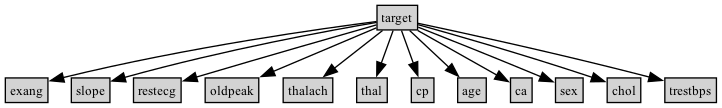

In [27]:
cl=projet.ReducedMLNaiveBayesClassifier(train,0.05)
cl.draw()

In [28]:
for i in [0,1,2]:
    print(f"Estimation de la proba de l'individu {i} par ReducedMLNaiveBayesClassifier : {cl.estimProbas(utils.getNthDict(train,i))}")
    print(f"Estimation de la classe de l'individu {i} par ReducedMLNaiveBayesClassifier : {cl.estimClass(utils.getNthDict(train,i))}") 
    print("------")
print(f"test en apprentissage : {cl.statsOnDF(train)}")
print(f"test en validation    : {cl.statsOnDF(test)}")

Estimation de la proba de l'individu 0 par ReducedMLNaiveBayesClassifier : {0: 3.302888250724298e-10, 1: 5.293870587952087e-11}
Estimation de la classe de l'individu 0 par ReducedMLNaiveBayesClassifier : 0
------
Estimation de la proba de l'individu 1 par ReducedMLNaiveBayesClassifier : {0: 0.0, 1: 2.386046156003524e-09}
Estimation de la classe de l'individu 1 par ReducedMLNaiveBayesClassifier : 1
------
Estimation de la proba de l'individu 2 par ReducedMLNaiveBayesClassifier : {0: 4.382121473000438e-10, 1: 1.9085511760059353e-06}
Estimation de la classe de l'individu 2 par ReducedMLNaiveBayesClassifier : 1
------
test en apprentissage : {'VP': 350, 'VN': 116, 'FP': 22, 'FN': 54, 'Précision': 0.9408602150537635, 'Rappel': 0.8663366336633663}
test en validation    : {'VP': 49, 'VN': 60, 'FP': 2, 'FN': 89, 'Précision': 0.9607843137254902, 'Rappel': 0.35507246376811596}


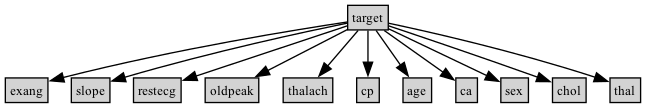

In [29]:
cl=projet.ReducedMLNaiveBayesClassifier(train,0.01)
cl.draw()

In [30]:
for i in [0,1,2]:
    print(f"Estimation de la proba de l'individu {i} par ReducedMLNaiveBayesClassifier : {cl.estimProbas(utils.getNthDict(train,i))}")
    print(f"Estimation de la classe de l'individu {i} par ReducedMLNaiveBayesClassifier : {cl.estimClass(utils.getNthDict(train,i))}") 
    print("------")
print(f"test en apprentissage : {cl.statsOnDF(train)}")
print(f"test en validation    : {cl.statsOnDF(test)}")

Estimation de la proba de l'individu 0 par ReducedMLNaiveBayesClassifier : {0: 5.697482232499415e-09, 1: 2.1387237175326438e-09}
Estimation de la classe de l'individu 0 par ReducedMLNaiveBayesClassifier : 0
------
Estimation de la proba de l'individu 1 par ReducedMLNaiveBayesClassifier : {0: 0.0, 1: 1.1475745797921712e-08}
Estimation de la classe de l'individu 1 par ReducedMLNaiveBayesClassifier : 1
------
Estimation de la proba de l'individu 2 par ReducedMLNaiveBayesClassifier : {0: 2.7487852876093664e-09, 1: 9.179222322695213e-06}
Estimation de la classe de l'individu 2 par ReducedMLNaiveBayesClassifier : 1
------
test en apprentissage : {'VP': 348, 'VN': 117, 'FP': 21, 'FN': 56, 'Précision': 0.943089430894309, 'Rappel': 0.8613861386138614}
test en validation    : {'VP': 49, 'VN': 61, 'FP': 1, 'FN': 89, 'Précision': 0.98, 'Rappel': 0.35507246376811596}


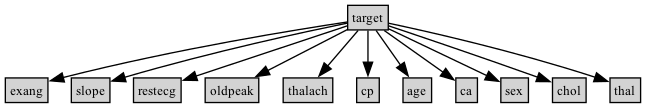

In [31]:
cl=projet.ReducedMAPNaiveBayesClassifier(train,0.01)
cl.draw()

In [32]:
for i in [0,1,2]:
    print(f"Estimation de la proba de l'individu {i} par ReducedMAPNaiveBayesClassifier : {cl.estimProbas(utils.getNthDict(train,i))}")
    print(f"Estimation de la classe de l'individu {i} par ReducedMAPNaiveBayesClassifier : {cl.estimClass(utils.getNthDict(train,i))}") 
    print("------")
print(f"test en apprentissage : {cl.statsOnDF(train)}")
print(f"test en validation    : {cl.statsOnDF(test)}")

Estimation de la proba de l'individu 0 par ReducedMAPNaiveBayesClassifier : {0: 0.47643095845795086, 1: 0.5235690415420491}
Estimation de la classe de l'individu 0 par ReducedMAPNaiveBayesClassifier : 1
------
Estimation de la proba de l'individu 1 par ReducedMAPNaiveBayesClassifier : {0: 0.0, 1: 1.0}
Estimation de la classe de l'individu 1 par ReducedMAPNaiveBayesClassifier : 1
------
Estimation de la proba de l'individu 2 par ReducedMAPNaiveBayesClassifier : {0: 0.00010227941341238205, 1: 0.9998977205865877}
Estimation de la classe de l'individu 2 par ReducedMAPNaiveBayesClassifier : 1
------
test en apprentissage : {'VP': 375, 'VN': 110, 'FP': 28, 'FN': 29, 'Précision': 0.9305210918114144, 'Rappel': 0.9282178217821783}
test en validation    : {'VP': 53, 'VN': 56, 'FP': 6, 'FN': 85, 'Précision': 0.8983050847457628, 'Rappel': 0.38405797101449274}


## 6- Evaluation des classifieurs

Nous commençons à avoir pas mal de classifieurs. Pour les comparer, une possibilité est d'utiliser la représentation graphique des points $(précision,rappel)$ de chacun (la précision et le rappel sont des valeurs entre $0$ et $1$).

### Question 6.1

![question.png](attachment:58c09129-5615-46d1-89ad-9af44f3e9f37.png) Où se trouve à votre avis le point idéal ? Comment pourriez-vous proposer de comparer les différents classifieurs dans cette représentation graphique ?

#### réponse
Le point idéal se trouve en (1, 1) avec précision et rappel à 1. On peut comparer les classifieurs avec la position des points par rapport à la base train et test, et la distance des points avec (1,1)?

### Question 6.2 

Écrire une fonction `mapClassifiers(dic,df)` qui, à partir d'un dictionnaire `dic` de `{nom:instance de classifier}` et d'un dataframe `df`, représente graphiquement ces classifiers dans l'espace $(précision,rappel)$.

In [ ]:
#added, in projet.py
def mapClassifiers(dic: dict,df: pd.DataFrame)->None:
    """
    Représente graphiquement les classifieurs avec en coordonnées (x, y) = (précision, rappel)

    Parameters
    ----------
        dic: Dict[nom, instance de classifieur] 
            le dictionnaire des noms et des instances de classifieurs à représenter.
        df: DataFrame
            la base de données sur lequel on va évaluer la précision et le rappel

    Returns
    -------
        None, ne revoie rien et affiche le graphique 
    """
    # objet figure 
    fig = plt.figure(facecolor='lightgray')

    # ajout d'un seul sous-graphe dans la figure
    ax = fig.add_subplot(111)

    # parcours des instances de classifieurs
    for name, instance in dic.items():

        # calcul des statistiques de qualité
        stats = instance.statsOnDF(df)
        x, y = stats['precision'], stats['rappel']

        # tracer le point
        ax.plot(x, y, 'rx')
        # ajout du nom du point
        ax.text(x, y, name, fontsize=10, verticalalignment='bottom', horizontalalignment='left')

    # Ecriture du nom des axes
    ax.set_xlabel('précision')
    ax.set_ylabel('rappel')

    # Affichage de la figure
    plt.show()


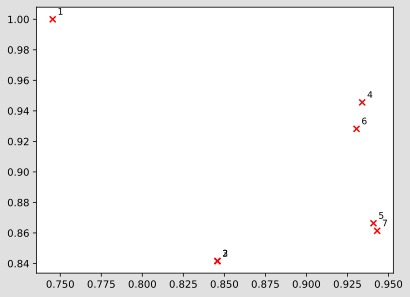

In [33]:
projet.mapClassifiers({"1":projet.APrioriClassifier(train),
                "2":projet.ML2DClassifier(train,"exang"),
                "3":projet.MAP2DClassifier(train,"exang"),
                "4":projet.MAPNaiveBayesClassifier(train),
                "5":projet.MLNaiveBayesClassifier(train),
                "6":projet.ReducedMAPNaiveBayesClassifier(train,0.01),
                "7":projet.ReducedMLNaiveBayesClassifier(train,0.01),
               },train)

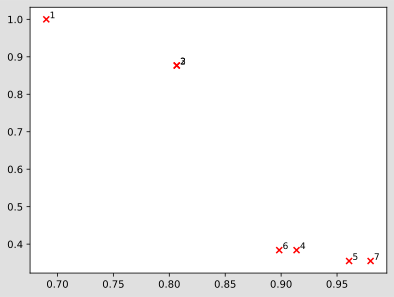

In [34]:
projet.mapClassifiers({"1":projet.APrioriClassifier(train),
                "2":projet.ML2DClassifier(train,"exang"),
                "3":projet.MAP2DClassifier(train,"exang"),
                "4":projet.MAPNaiveBayesClassifier(train),
                "5":projet.MLNaiveBayesClassifier(train),
                "6":projet.ReducedMAPNaiveBayesClassifier(train,0.01),
                "7":projet.ReducedMLNaiveBayesClassifier(train,0.01),
               },test)

### Question 6.3 : Conclusion

![question.png](attachment:d8c57fb8-5f80-4627-b26a-ea3c8351cae4.png) Qu'en concluez vous ?

## 7- Sophistication du modèle (question BONUS)

Utiliser un arbre pour représenter la factorisation de la loi jointe est bien sûr une simplification : beaucoup de distribution ne peuvent être représentées avec un seul parent par variable.

Un modèle plus sophisitiqué existe donc : le TAN (Tree-augmented Naïve Bayes). Il consiste à rajouter au plus un parent à chaque attribut parmi les autres attributs (sans créer de cycle). En plus des arcs les reliant à la classe, un TABN induit donc un arbre (plus exactement une forêt) parmi les attributs.

Ci-dessous un TAN dont la classe est $T$.

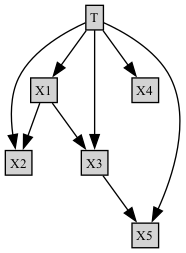

In [35]:
utils.drawGraph("T->X1;T->X2;T->X3;T->X4;T->X5;X1->X2;X1->X3;X3->X5")

et dont l'arbre (la forêt) sur les attributs est bien :

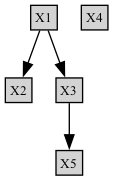

In [36]:
utils.drawGraph("X1->X2;X1->X3;X3->X5;X4")

L'algorithme pour générer cette structure se base sur une autre façon de tester l'indépendance entre deux variables aléatoires : l'information mutuelle qui calcule une distance entre la distribution des 2 variables et la distribution si ces 2 variables étaient indépendantes (voir https://fr.wikipedia.org/wiki/Information_mutuelle). Pour construire l'arbre (la forêt) entre les attributs, sachant qu'on garde les arcs issus de la classe, il faut tester des indépendances conditionnelles et donc calculer des informations mutuelles conditionnelles (https://en.wikipedia.org/wiki/Conditional_mutual_information).

On gardera de ces pages les deux formules :
$$I(X;Y)=\sum_{x,y} P(x,y)\log_2\frac{P(x,y)}{P(x)P(y)}$$

$$I(X;Y|Z)=\sum_{z,x,y} P(x,y,z)\log_2\frac{P(z)P(x,y,z)}{P(x,z)P(y,z)}$$

Et on remarquera que :
- $P(x,z)=\sum_y P(x,y,z)$, 
- $P(y,z)=\sum_x P(x,y,z)$, 
- $P(z)=\sum_{x,y} P(x,y,z)$, 
- etc.

### Question 7.1 : calcul des informations mutuelles
Écrire des fonctions `projet.MutualInformation(df,x,y)` et `projet.ConditionalMutualInformation(df,x,y,z)` qui calcule ces informations mutuelles

In [37]:
for attr in train.keys():
    if attr!='target':
        print(f"target->{attr:10} : {projet.MutualInformation(train,'target',attr):5.7f}")

target->age        : 0.0590907
target->sex        : 0.0359445
target->cp         : 0.1599540
target->trestbps   : 0.0411980
target->chol       : 0.0405824
target->fbs        : 0.0000413
target->restecg    : 0.0161392
target->thalach    : 0.1401572
target->exang      : 0.1014837
target->oldpeak    : 0.1393573
target->slope      : 0.0938838
target->ca         : 0.1405104
target->thal       : 0.1625536


(On retrouve au passage que `trestbs` et surtout `fbs` sont très peu dépendantes de la classe ...)

On peut également calculer la matrice des informations mutuelles entre attributs, conditionnellement à `target`.

In [38]:
cmis=np.array([[0 if x==y else projet.ConditionalMutualInformation(train,x,y,"target") 
                for x in train.keys() if x!="target"]
               for y in train.keys() if y!="target"])
cmis[0:5,0:5] # on affiche qu'une partie 5x5 de la matrice

array([[0.        , 0.07172827, 0.20250622, 0.6417183 , 0.55128095],
       [0.07172827, 0.        , 0.01672381, 0.06361231, 0.12140024],
       [0.20250622, 0.01672381, 0.        , 0.22413205, 0.18890573],
       [0.6417183 , 0.06361231, 0.22413205, 0.        , 0.68149423],
       [0.55128095, 0.12140024, 0.18890573, 0.68149423, 0.        ]])

(on remarque que, évidemment, la matrice `cmis` est symétrique)

### Question 7.2 : calcul de la matrice des poids
La matrice `cmis` calculé ci-dessus représente l'ensemble des arcs possibles entre les attributs et leur poids. Pour trouver un arbre dans ces arcs, on commence par simplifier cette matrice en supprimant les poids faibles. Par exemple, en retirant la moyenne.

Faites une fonction `projet.MeanForSymetricWeights(a)` qui calcule la moyenne des poids pour une matrice `a` symétrique de diagonale nulle.

Puis écrire une fonction `projet.simplifyContitionalMutualInformationMatrix(a)` qui annule toutes les valeurs plus petites que cette moyenne dans une matrice  `a` symétrique de diagonale nulle.

In [39]:
projet.MeanForSymetricWeights(cmis)

0.14490408192274776

In [40]:
projet.SimplifyConditionalMutualInformationMatrix(cmis)
cmis[0:5,0:5]

array([[0.        , 0.        , 0.20250622, 0.6417183 , 0.55128095],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.20250622, 0.        , 0.        , 0.22413205, 0.18890573],
       [0.6417183 , 0.        , 0.22413205, 0.        , 0.68149423],
       [0.55128095, 0.        , 0.18890573, 0.68149423, 0.        ]])

### Question 7.3 : Arbre (forêt) optimal entre les attributs

Un algorithme pour trouver un arbre de poids maximal est l'algorithm de Kruskal (https://fr.wikipedia.org/wiki/Algorithme_de_Kruskal). En se souvenant qu'on veut relier les attributs si ils sont très dépendants, écrire la fonction `projet.Kruskal(df,a)` qui propose la liste des arcs (non orientés pour l'instant) à ajouter dans notre classifieur sous la forme d'une liste de triplet $(attr1,attr2,poids)$. 

<b>Remarque</b> : `df` ne sert ici qu'à retrouver le nom des attributs à partir de leur indice grâce à `train.keys()[i]`.

In [41]:
liste_arcs=projet.Kruskal(train,cmis)
liste_arcs

[('trestbps', 'chol', np.float64(0.6814942282235203)),
 ('age', 'trestbps', np.float64(0.641718295908513)),
 ('age', 'thalach', np.float64(0.6365766485465845)),
 ('chol', 'oldpeak', np.float64(0.5246930555244587)),
 ('oldpeak', 'slope', np.float64(0.25839871090530614)),
 ('chol', 'ca', np.float64(0.2528327956181666))]

### Question 7.4: Orientation des arcs entre attributs.

Il s'agit maintenant d'orienter l'arbre (la forêt) entre les attributs. On choisit la (ou les) racine(s) en maximisant l'information mutuelle entre ces attributs et la classe (donc en utilisant `projet.MutualInformation`.

Créer une fonction `projet.ConnexSet(list_arcs)` qui rend une liste d'ensemble d'attributs connectés, 

In [42]:
# 3 arcs de poids quelconques dans le graphe a--b--c   d--e
projet.ConnexSets([('a','b',0.878),
                   ('a','c',0.4568),
                   ('d','e',0.123156)])

[{'a', 'b', 'c'}, {'d', 'e'}]

In [43]:
projet.ConnexSets(liste_arcs)

[{'age', 'ca', 'chol', 'oldpeak', 'slope', 'thalach', 'trestbps'}]

Puis écrire une fonction `projet.OrientConnexSets(df,arcs,classe)` qui utilise l'information mutuelle (entre chaque attribut et la `classe`) pour proposer pour chaque ensemble d'attributs connexes une racine et qui rend la liste des arcs orientés.

In [44]:
projet.OrientConnexSets(train,liste_arcs,'target')

[('ca', 'chol'),
 ('chol', 'trestbps'),
 ('trestbps', 'age'),
 ('age', 'thalach'),
 ('chol', 'oldpeak'),
 ('oldpeak', 'slope')]

### Question 7.5: Classifieur TAN
Écrire un `MAPTANClassifier(df)` qui construit un modèle TAN en suivant la procédure ci-dessus. Lui ajouter une procédure `Draw()`

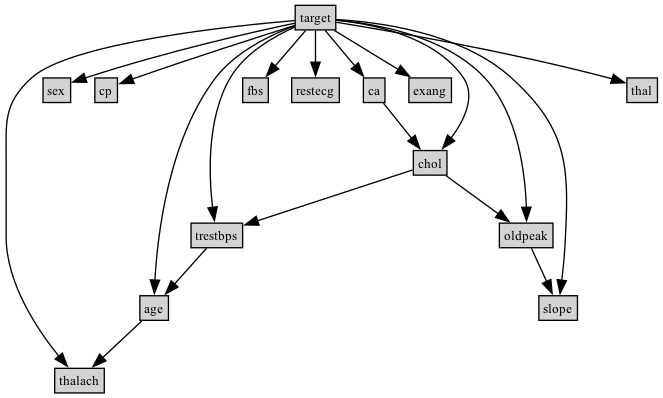

In [45]:
tan=projet.MAPTANClassifier(train)
tan.draw()

In [46]:
for i in [0,1,2]:
    print(f"Estimation de la proba de l'individu {i} par ReducedMAPNaiveBayesClassifier : {tan.estimProbas(utils.getNthDict(train,i))}")
    print(f"Estimation de la classe de l'individu {i} par ReducedMAPNaiveBayesClassifier : {tan.estimClass(utils.getNthDict(train,i))}") 
    print("------")
print(f"test en apprentissage : {tan.statsOnDF(train)}")
print(f"test en validation    : {tan.statsOnDF(test)}")

Estimation de la proba de l'individu 0 par ReducedMAPNaiveBayesClassifier : {0: 0.022097318917168225, 1: 0.9779026810828317}
Estimation de la classe de l'individu 0 par ReducedMAPNaiveBayesClassifier : 1
------
Estimation de la proba de l'individu 1 par ReducedMAPNaiveBayesClassifier : {0: 0.0002558573810941134, 1: 0.999744142618906}
Estimation de la classe de l'individu 1 par ReducedMAPNaiveBayesClassifier : 1
------
Estimation de la proba de l'individu 2 par ReducedMAPNaiveBayesClassifier : {0: 2.890636636415822e-06, 1: 0.9999971093633636}
Estimation de la classe de l'individu 2 par ReducedMAPNaiveBayesClassifier : 1
------
test en apprentissage : {'VP': 403, 'VN': 112, 'FP': 26, 'FN': 1, 'Précision': 0.9393939393939394, 'Rappel': 0.9975247524752475}
test en validation    : {'VP': 127, 'VN': 52, 'FP': 10, 'FN': 11, 'Précision': 0.927007299270073, 'Rappel': 0.9202898550724637}


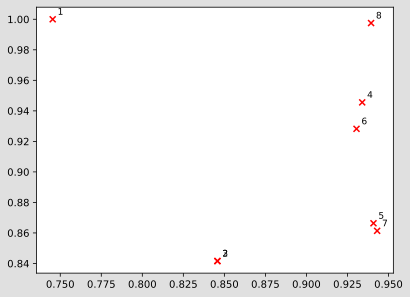

In [47]:
projet.mapClassifiers({"1":projet.APrioriClassifier(train),
                "2":projet.ML2DClassifier(train,"exang"),
                "3":projet.MAP2DClassifier(train,"exang"),
                "4":projet.MAPNaiveBayesClassifier(train),
                "5":projet.MLNaiveBayesClassifier(train),
                "6":projet.ReducedMAPNaiveBayesClassifier(train,0.01),
                "7":projet.ReducedMLNaiveBayesClassifier(train,0.01),
                "8":projet.MAPTANClassifier(train),
               },train)

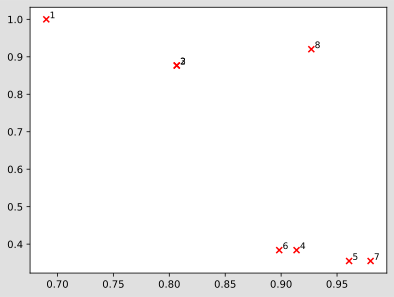

In [48]:
projet.mapClassifiers({"1":projet.APrioriClassifier(train),
                "2":projet.ML2DClassifier(train,"exang"),
                "3":projet.MAP2DClassifier(train,"exang"),
                "4":projet.MAPNaiveBayesClassifier(train),
                "5":projet.MLNaiveBayesClassifier(train),
                "6":projet.ReducedMAPNaiveBayesClassifier(train,0.01),
                "7":projet.ReducedMLNaiveBayesClassifier(train,0.01),
                "8":projet.MAPTANClassifier(train),
               },test)

## 8- Conclusion finale

![question.png](attachment:2a27ad50-6b2f-4c3f-ac0c-33b155d0ee9a.png)
Quelle leçons & conclusion tirez-vous de ces expériences sur les classifieurs bayésiens ?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=540b9bcd-deb1-4efe-a672-d3de7cb6cc2e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>